In [ ]:
import os
import pandas as pd
import keras
from keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from keras.models import load_model
from keras.models import Model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import joblib
import pickle
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve

import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_train = np.load('drive/MyDrive/lid_data/X_train.npy')
y_train = np.load('drive/MyDrive/lid_data/y_train.npy')

In [ ]:
X_validation = np.load('drive/MyDrive/lid_data/X_validation.npy')
y_validation = np.load('drive/MyDrive/lid_data/y_validation.npy')

In [ ]:
X_test = np.load('drive/MyDrive/lid_data/X_test.npy')
y_test = np.load('drive/MyDrive/lid_data/y_test.npy')

In [ ]:
print(X_train.shape)

print(X_test.shape)

print(X_validation.shape)

(10336, 188, 13)
(1292, 188, 13)
(1292, 188, 13)


In [ ]:
print(y_train.shape)

print(y_test.shape)

print(y_validation.shape)

(10336,)
(1292,)
(1292,)


In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

In [ ]:
print(unique_elements,counts_elements)

[0 1 2 3 4] [2285 1910 1975 1947 2219]


In [ ]:
unique_elements, counts_elements = np.unique(y_test, return_counts=True)
print(unique_elements,counts_elements)

[0 1 2 3 4] [264 238 251 264 275]


In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

class SaveBestRatioCallback(tf.keras.callbacks.Callback):
    def __init__(self, filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max'):
        super(SaveBestRatioCallback, self).__init__()
        self.filepath = filepath
        self.monitor = monitor
        self.verbose = verbose
        self.save_best_only = save_best_only
        self.mode = mode
        self.best_ratio = -float('inf') if mode == 'max' else float('inf')

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        val_accuracy = logs.get('val_accuracy')

        if val_loss is None or val_accuracy is None:
            return

        current_ratio = val_accuracy / val_loss

        if self.mode == 'max':
            if current_ratio > self.best_ratio:
                self.best_ratio = current_ratio
                if self.save_best_only:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: val_acc/val_loss improved to {current_ratio:.4f}, saving model to {self.filepath}')
                    self.model.save(self.filepath)
        else:
            if current_ratio < self.best_ratio:
                self.best_ratio = current_ratio
                if self.save_best_only:
                    if self.verbose > 0:
                        print(f'\nEpoch {epoch + 1}: val_acc/val_loss improved to {current_ratio:.4f}, saving model to {self.filepath}')
                    self.model.save(self.filepath)

def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation,checkpoint_path):
    """Trains model
    :param epochs (int): Num training epochs
    :param batch_size (int): Samples per batch
    :param patience (int): Num epochs to wait before early stop, if there isn't an improvement on accuracy
    :param X_train (ndarray): Inputs for the train set
    :param y_train (ndarray): Targets for the train set
    :param X_validation (ndarray): Inputs for the validation set
    :param y_validation (ndarray): Targets for the validation set
    :return history: Training history
    """
    Learning_Rate_Scheduler = keras.callbacks.LearningRateScheduler(scheduler)
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="accuracy", min_delta=0.001, patience=patience)
    checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    # train model
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[checkpoint_callback], verbose=1)
    #callbacks=[earlystop_callback, checkpoint_callback,Learning_Rate_Scheduler]
    return history


In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
    :param history: Training history of model
    :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

    # Exclude the first few epochs so the graph is easier to read

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'g.', label='Training loss')
    plt.plot(epochs, val_loss, 'rx', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
from keras.models import Sequential
#from keras.layers import Conv1D, Flatten, GlobalAveragePooling1D, Dense
from keras.layers import Conv1D, Flatten, GlobalAveragePooling1D, Dense, MaxPooling1D

def build_1D_CNN_model(input_shape, NCLASS, learning_rate , loss="sparse_categorical_crossentropy"):
    model = Sequential()

    # Add 1D-CNN layers
    model.add(Conv1D(filters=100, kernel_size=3, strides=1, activation='relu', input_shape= input_shape))   #(None, 1)
    model.add(Conv1D(filters=300, kernel_size=3, strides=1, activation='relu'))
    model.add(Conv1D(filters=500, kernel_size=3, strides=1, activation='relu'))
    #model.add(Conv1D(filters=500, kernel_size=3, strides=1, activation='relu'))
    #model.add(Conv1D(filters=500, kernel_size=3, strides=1, activation='relu'))
    #model.add(Conv1D(filters=500, kernel_size=2, strides=2, activation='relu'))
    #model.add(Conv1D(filters=500, kernel_size=2, strides=2, activation='relu'))
    #model.add(keras.layers.Dropout(0.3))

    # Global average pooling
    model.add(GlobalAveragePooling1D())

    #model.add(MaxPooling1D(2))
    #model.add(MaxPooling1D(2))
    model.add(Flatten())
    # Fully connected layers
    #model.add(Dense(1024, activation='relu'))
    #model.add(keras.layers.Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    #model.add(Dense(256, activation='relu'))
    #model.add(keras.layers.Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    # Softmax layer
    model.add(Dense(NCLASS, activation='softmax'))


    optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9,beta_2=0.99)
    #optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9)
    #optimiser = keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

    model.compile(optimizer=optimizer, loss=loss,metrics=["accuracy"])

    model.summary()

    return model

In [ ]:

EPOCHS = 50
BATCH_SIZE = 128
LEARNING_RATE = 0.001
PATIENCE = 5

In [ ]:

class_list, frequency = np.unique(y_train,return_counts = True)

print(class_list)

NCLASS=len(class_list)


print(NCLASS)



[0 1 2 3 4]
5


In [ ]:
class_names = ['English','French', 'German','Portuguese','Tamil']

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 182, 500)            │         450,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 500)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         256,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 867,621 (3.31 MB)

 Trainable params: 867,621 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4004 - loss: 1.3200
Epoch 1: val_accuracy improved from -inf to 0.66796, saving model to drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 63ms/step - accuracy: 0.4015 - loss: 1.3180 - val_accuracy: 0.6680 - val_loss: 0.8881
Epoch 2/50
79/81 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6676 - loss: 0.8567
Epoch 2: val_accuracy improved from 0.66796 to 0.74690, saving model to drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.6686 - loss: 0.8549 - val_accuracy: 0.7469 - val_loss: 0.6824
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7508 - loss: 0.6832
Epoch 3: val_accuracy improved from 0.74690 to 0.80186, saving model to drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.7510 - loss: 0.6828 - val_accuracy: 0.8019 - val_loss: 0.5377
Epoch 4/50
79/81 ━━━━━━━━

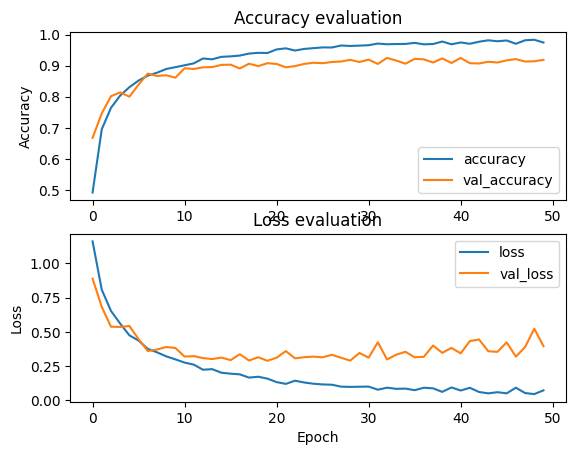

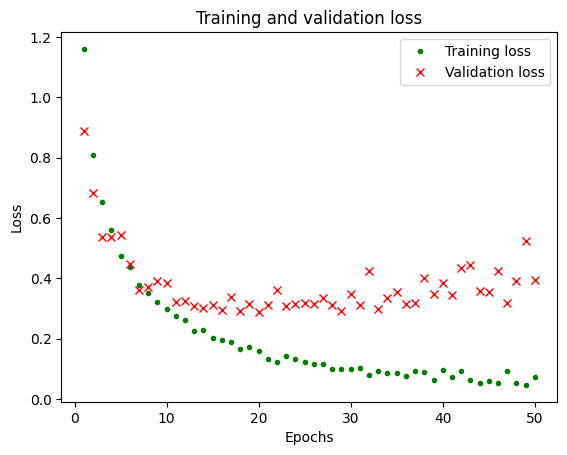

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9405 - loss: 0.2874

Test loss: 0.2871800363063812, test accuracy on last model: 93.18885207176208


In [ ]:
checkpoint_path = "drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras"
SAVED_MODEL_PATH = "drive/MyDrive/lid_kd_project/1D_CNN_model_last.keras"

# create network
input_shape = (X_train.shape[1], X_train.shape[2])



model = build_1D_CNN_model(input_shape, NCLASS, learning_rate=LEARNING_RATE)

# train network
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, X_train, y_train, X_validation, y_validation,checkpoint_path)

# plot accuracy/loss for training/validation set as a function of the epochs
plot_history(history)

# Check if the file already exists and delete it
if os.path.exists(SAVED_MODEL_PATH):
    os.remove(SAVED_MODEL_PATH)


# save model
model.save(SAVED_MODEL_PATH)


# evaluate latest network on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy on last model: {}".format(test_loss, 100*test_acc))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9405 - loss: 0.2874

Test loss: 0.2871800363063812, test accuracy on best model: 93.18885207176208
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Confusion Matrix:
[[244   7   8   5   0]
 [  6 217   5  10   0]
 [ 10   6 231   4   0]
 [  9   9   0 246   0]
 [  2   4   0   3 266]]
              precision    recall  f1-score   support

     English       0.90      0.92      0.91       264
      French       0.89      0.91      0.90       238
      German       0.95      0.92      0.93       251
  Portuguese       0.92      0.93      0.92       264
       Tamil       1.00      0.97      0.98       275

    accuracy                           0.93      1292
   macro avg       0.93      0.93      0.93      1292
weighted avg       0.93      0.93      0.93      1292


Precision: 0.9328078976682053
Recall: 0.9318885448916409
F1 Score: 0.9321934524910802
Macro-average AUC-ROC Score: 0.9942966989038418
Weighted-average AUC-ROC Score: 0.994348760301896


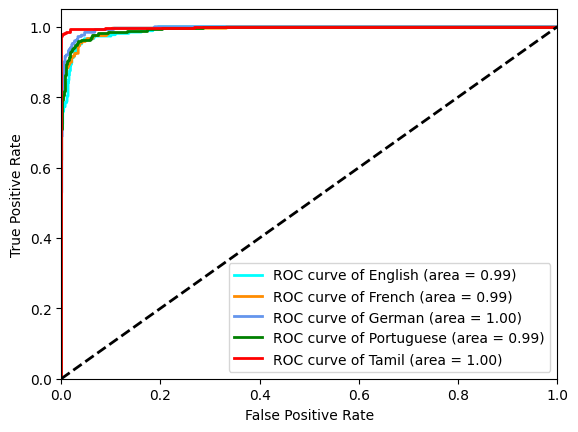

In [ ]:
# evaluate the best network on test set
model = load_model("drive/MyDrive/lid_kd_project/1D_CNN_model_last.keras")
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy on best model: {}".format(test_loss, 100*test_acc))



# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class
y_pred = y_pred_probs.argmax(axis=1)  # Extracting the index of the class with the

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# show classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# Calculate precision, recall, and F1 score (use 'average' parameter for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


# Binarize the output labels for multiclass ROC AUC computation
y_bin = label_binarize(y_test, classes=np.arange(NCLASS))

#print(f"y shape: {y.shape}")
#print(f"y_pred_prob shape: {y_pred_prob.shape}")

# Compute AUC-ROC score for each class
auc_scores = []
for i in range(NCLASS):
    auc = roc_auc_score(y_bin[:, i], y_pred_probs[:, i])
    auc_scores.append(auc)
    #print(f"AUC-ROC Score for class {class_names[i]}: {auc}")

# Compute macro-average AUC-ROC score
macro_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="macro", multi_class="ovr")
print(f"Macro-average AUC-ROC Score: {macro_roc_auc_ovr}")

# Compute weighted-average AUC-ROC score
weighted_roc_auc_ovr = roc_auc_score(y_bin, y_pred_probs, average="weighted", multi_class="ovr")
print(f"Weighted-average AUC-ROC Score: {weighted_roc_auc_ovr}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(NCLASS):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_probs[:, i])

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
plt.figure()
for i, color in zip(range(NCLASS), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of {0} (area = {1:0.2f})'.format(class_names[i], auc_scores[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver Operating Characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
########################

10
[<Conv1D name=conv1d_6, built=True>, <Conv1D name=conv1d_7, built=True>, <Conv1D name=conv1d_8, built=True>, <GlobalAveragePooling1D name=global_average_pooling1d_2, built=True>, <Flatten name=flatten_2, built=True>, <Dense name=dense_6, built=True>, <Dropout name=dropout_4, built=True>, <Dense name=dense_7, built=True>, <Dropout name=dropout_5, built=True>, <Dense name=dense_8, built=True>]
10


Model: "functional_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 188, 13)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 186, 100)            │           4,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 184, 300)            │          90,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_8 (Conv1D)                    │ (None, 182, 500)            │         450,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_2           │ (None, 500)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 500)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 544,800 (2.08 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 544,800 (2.08 MB)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


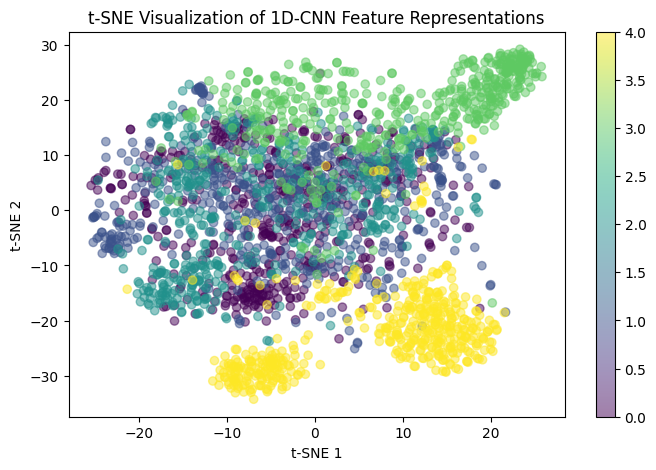

In [ ]:
X_test = np.load('drive/MyDrive/lid_test_set_small/1D_CNN_X_test_short.npy')
y_test = np.load('drive/MyDrive/lid_test_set_small/1D_CNN_y_test_short.npy')

model = load_model("drive/MyDrive/lid_kd_project/1D_CNN_model_best.keras")

num_layers = len(model.layers)

print(num_layers)

print(model.layers)

# Freeze all layers except the last one
count = 0
for layer in model.layers:
  layer.trainable = False
  count += 1

print(count)


input_layer_input = model.layers[-10].input

last_layer_output = model.layers[-6].output

# Create a new model to output the feature representations
intermediate_layer_model = Model(inputs=input_layer_input, outputs=last_layer_output)

optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.99)

intermediate_layer_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy",metrics=["accuracy"])

intermediate_layer_model.summary()



# Get feature representations for the training data
features = intermediate_layer_model.predict(X_test)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(tensor_2d)

# Plot the t-SNE output
plt.figure(figsize=(8, 5))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE Visualization of 1D-CNN Feature Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


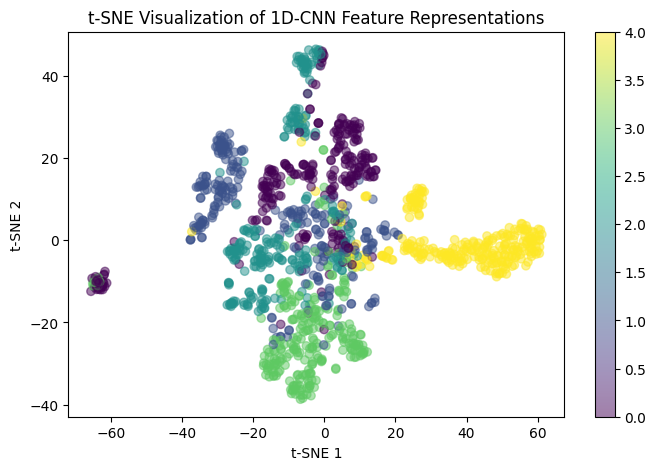

In [ ]:
# Get feature representations for the training data
features = intermediate_layer_model.predict(X_test)

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(features)

# Plot the t-SNE output
plt.figure(figsize=(8, 5))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test, cmap='viridis', alpha=0.5)
plt.colorbar()
plt.title('t-SNE Visualization of 1D-CNN Feature Representations')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

In [ ]:
features.shape

(2500, 500)

In [ ]:
X_test.shape

(1292, 188, 13)

In [ ]:
tensor_2d = X_test.reshape(X_test.shape[0], -1)

In [ ]:
y_test .shape

(1292,)

In [ ]:
class_list, frequency = np.unique(y_test,return_counts = True)

print(frequency)

[264 238 251 264 275]


In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("\nTest loss: {}, test accuracy on best model: {}".format(test_loss, 100*test_acc))

# Making predictions on the test set
y_pred_probs = model.predict(X_test)  # Assuming model output probabilities for each class
y_pred = y_pred_probs.argmax(axis=1)  # Extracting the index of the class with the

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# show classification report
print(classification_report(y_test, y_pred, target_names=class_names))

# Calculate precision, recall, and F1 score (use 'average' parameter for multi-class problems)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9402 - loss: 0.2241

Test loss: 0.23919181525707245, test accuracy on best model: 93.11145544052124
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Confusion Matrix:
[[247   2   9   4   2]
 [ 10 215   3  10   0]
 [  9   5 235   2   0]
 [ 10   8   6 238   2]
 [  3   1   1   2 268]]
              precision    recall  f1-score   support

     English       0.89      0.94      0.91       264
      French       0.93      0.90      0.92       238
      German       0.93      0.94      0.93       251
  Portuguese       0.93      0.90      0.92       264
       Tamil       0.99      0.97      0.98       275

    accuracy                           0.93      1292
   macro avg       0.93      0.93      0.93      1292
weighted avg       0.93      0.93      0.93      1292


Precision: 0.9317750568300608
Recall: 0.9311145510835913
F1 Score: 0.9312082702227154


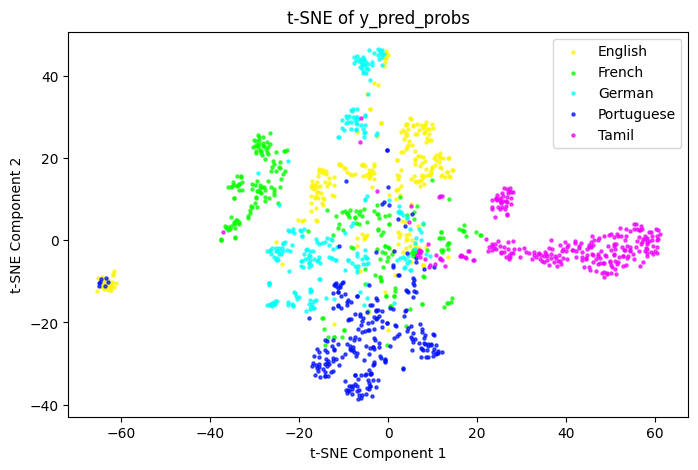

In [ ]:
# Plot the data with different colors for different classes
plt.figure(figsize=(8, 5))
palette = sns.color_palette("hsv", len(class_names)) # Choose a color palette

for i, label in enumerate(class_names):
    idx = y_test == i
    plt.scatter(features_2d[idx, 0],features_2d[idx, 1], s=5, alpha=0.7, color=palette[i], label=class_names[i])

plt.title('t-SNE of y_pred_probs')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()